In [2]:
%pip install matplotlib
%pip install scikit-learn
%pip install pandas


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.models import load_model
model = load_model("modelo_mobilenetv2_papayas.h5")

In [4]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Rutas y configuración
data_dir = "resized/train"
img_size = (224, 224)
batch_size = 32

val_dir   = "resized/test"

# Cargar dataset (misma división que usaste antes)
val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Guardar nombres de clase
class_names = val_ds.class_names



Found 180 files belonging to 3 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


<Figure size 600x600 with 0 Axes>

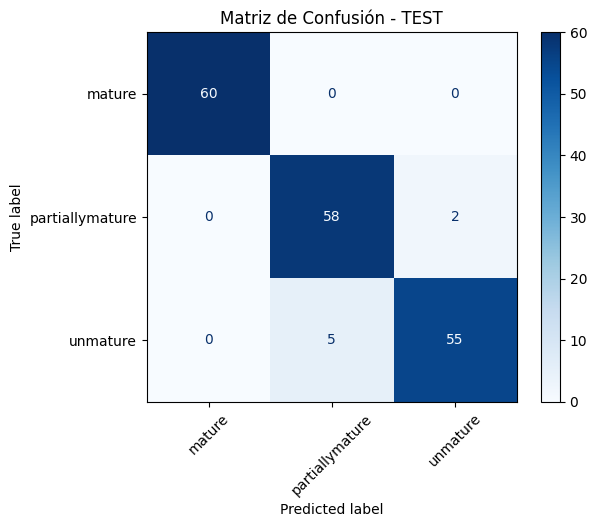

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Obtener etiquetas reales y predichas del set de validación
y_true = []
y_pred = []

for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Mostrar matriz
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión - TEST")
plt.show()



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Ruta de la imagen de prueba
img_path = "resized/valid/partiallymature/PartiallyMature_001.jpg"

# Preprocesar imagen
img = image.load_img(img_path, target_size=(224, 224))  # Debe coincidir con el tamaño usado en entrenamiento
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Forma (1, 224, 224, 3)
img_array = img_array / 255.0  # Normalizar

# Predecir
preds = model.predict(img_array)
predicted_class = np.argmax(preds, axis=1)[0]

# Mostrar resultado
print(f"🔍 Predicción: {class_names[predicted_class]}")
print("🧠 Clases del modelo:", class_names)
print("🖼 Imagen que vas a predecir:", img_path)

print("🧪 Tamaño original:", img.size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
🔍 Predicción: unmature
🧠 Clases del modelo: ['mature', 'partiallymature', 'unmature']
🖼 Imagen que vas a predecir: resized/valid/partiallymature/PartiallyMature_001.jpg
🧪 Tamaño original: (224, 224)


In [11]:
results = []
image_dir = "resized/test"

# Recorrer imágenes
for class_name in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        try:
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) 

            preds = model.predict(img_array, verbose=0)

            predicted_class = class_names[np.argmax(preds)]

            results.append({
                "Archivo": img_file,
                "Ruta": img_path,
                "Clase Verdadera": class_name,
                "Predicción": predicted_class,
                "Probabilidades": preds[0].tolist()
            })

        except Exception as e:
            results.append({
                "Archivo": img_file,
                "Ruta": img_path,
                "Clase Verdadera": class_name,
                "Predicción": "ERROR",
                "Probabilidades": str(e)
            })

# Guardar en CSV
df_results = pd.DataFrame(results)
df_results.to_csv("predicciones_test.csv", index=False)
print("✅ Resultados guardados en predicciones_test.csv")

✅ Resultados guardados en predicciones_test.csv


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Leer CSV generado con tus predicciones
df = pd.read_csv("predicciones_test.csv")

# Filtrar solo los casos válidos
df = df[df["Predicción"] != "ERROR"]

# Etiquetas reales y predichas
y_true = df["Clase Verdadera"]
y_pred = df["Predicción"]

# ===== 1. Matriz de Confusión =====
cm = confusion_matrix(y_true, y_pred, labels=sorted(df["Clase Verdadera"].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df["Clase Verdadera"].unique()))

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("🔍 Matriz de Confusión - TEST")
plt.show()

# ===== 2. Reporte de Clasificación =====
print("\n📋 Reporte de clasificación:")
print(classification_report(y_true, y_pred))

# ===== 3. Gráfico de aciertos vs errores por clase =====
aciertos = (y_true == y_pred)
df["Acierto"] = aciertos

aciertos_por_clase = df.groupby("Clase Verdadera")["Acierto"].sum()
total_por_clase = df["Clase Verdadera"].value_counts()

errores_por_clase = total_por_clase - aciertos_por_clase

# Crear gráfico
labels = total_por_clase.index.tolist()
x = range(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x, total_por_clase[labels], label='Total', alpha=0.5)
plt.bar(x, aciertos_por_clase[labels], label='Aciertos', alpha=0.9)
plt.bar(x, errores_por_clase[labels], label='Errores', alpha=0.9, color='red', bottom=aciertos_por_clase[labels])

plt.xticks(x, labels)
plt.ylabel("Cantidad")
plt.title("📊 Aciertos y errores por clase (TEST)")
plt.legend()
plt.tight_layout()
plt.show()


ValueError: 'labels' should contains at least one label.

In [10]:
%pip install pandas

import os
import numpy as np
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Ruta
img_path = "PAPAYANOMADURA2.jpg"
img_size = (224, 224)

# Cargar modelo
model = load_model("modelo_mobilenetv2_papayas.h5")
class_names = ['mature', 'partiallymature', 'unmature']  # Asegúrate de que coincidan

# Preprocesamiento SIN normalizar manualmente
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # NO hacer / 255

# Predicción
preds = model.predict(img_array)
predicted_class = class_names[np.argmax(preds)]

print(f"🔍 Predicción: {predicted_class}")
print("🧠 Probabilidades:", preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
🔍 Predicción: unmature
🧠 Probabilidades: [1.4395276e-04 2.8766057e-01 7.1219540e-01]
